# Code related to my critique of the Tsai et al 2017 papers
By Markus Meister, 3/7/18

The references used below are:

[1] Tsai, D., Yuste, R., and Shepard, K.L. (2017). Statistically Reconstructed Multiplexing for Very Dense, High-Channel-Count Acquisition Systems. IEEE Transactions on Biomedical Circuits and Systems 1–11.

[2] Tsai, D., Sawyer, D., Bradd, A., Yuste, R., and Shepard, K.L. (2017). A very large-scale microelectrode array for cellular-resolution electrophysiology. Nat Commun 8, 1802.

## Some useful functions:

In [17]:
from scipy import fftpack, signal
import matplotlib.pyplot as plt
import numpy as np

def resample(x,num):
    """
    Resamples the numpy array x to num points.
    Stripped-down and corrected version of signal.resample().
    Does resampling in frequency domain.
    For upsampling, zeros the high frequency components in the FT of the target array.
    For downsampling, discards the high frequencies from the source array, which corresponds to the ideal antialias filter.
    """
    X = fftpack.fft(x) # complex fourier transform
    Nx = len(x) # old number of points to be transformed
    N = int(np.minimum(num, Nx)) # the smaller of the old and new number of points
    Y = np.zeros(num, 'D') # complex number array with the new number of points. 
    sl = slice(0, (N + 1) // 2) # for N even this selects the first N/2 elements
    Y[sl] = X[sl]
    sl = slice(-(N - 1) // 2, None) # for N even this selects the last N/2 elements
    Y[sl] = X[sl]
    if N%2==0: # if the low number of points is even need to take special care. So far we have set Y[-N/2]=X[-N/2]
        if N<Nx: # if downsampling
            sl = slice(N//2,N//2+1,None) # select the component at frequency N/2
            Y[sl]+=X[sl] # add the component of X at N/2 
        elif N<num: # if upsampling
            sl = slice(num-N//2,num-N//2+1,None) # select the component at frequency -N/2
            Y[sl]/=2 # halve the component at -N/2 
            temp=Y[sl]
            sl = slice(N//2,N//2+1,None) # select the component at +N/2
            Y[sl]=temp # set that equal to the component at -N/2
    y = fftpack.ifft(Y) * (float(num) / float(Nx)) # inverse transform with proper normalization
    if x.dtype.char not in ['F', 'D']:
        y = y.real
    return y
    
def Filter_Sine(x,sup=1):
    """
    Extracts a single sine wave from a noisy signal.
    Finds the peak of the Fourier transform and suppresses all other frequency components.
    x = array with signal + noise
    sup = degree of suppression
    """
    f = np.fft.rfft(x) # FT of x
    fa = np.abs(f) # absolute value of the FT
    fam = np.max(fa) # find peak of abs value of FT
    yf = f * (fa/fam)**sup # suppress the off-peak components
    return np.fft.irfft(yf) # inverse FT to get the cleaned up sine wave

def Filter_Wiener(x,p):
    """
    Implements the Wiener filter
    x = time series of signal + noise (N points)
    p = signal/(signal+noise) power ratio as a function of frequency (N//2+1 points)
    returns: estimate of signal with noise suppressed
    """
    return np.fft.irfft(np.fft.rfft(x)*p)
        
def Filter_Tsai(x,v,r):
    """
    Implements the reconstruction algorithm of Tsai et al 2017
    x = signal + aliased noise at the single-channel sampling rate
    v = rms voltage of the broadband white noise 
    r = aliasing ratio, i.e. (bandwidth of noise) / (0.5 * sampling rate)
    returns: estimate of signal with aliased noise removed
    """
    # comments refer to equations on p.6 of doi:10.1109/TBCAS.2017.2750484 
    Fa = v*np.sqrt(np.pi*len(x))/2 # This is mean(|F(a_m)|) for gaussian white noise, computed rather than simulated
    Fb = v*np.sqrt(np.pi*len(x))/2/np.sqrt(r) # This is mean(|F(b_m)|) for gaussian white noise after anti-alias filtering
    rho = Fa - Fb # This is rho'_m
    Fy = np.fft.rfft(x) # FT of the input array
    Fz = Fy*(1-rho/np.abs(Fy)) # scale each coefficient as in the equation for o_m
    return np.fft.irfft(Fz) # inverse FT, this is o_m
    
def SNR(s,y):
    """
    Computes the signal-to-noise power ratio for the encoding of signal s in the time series y.
    Allows for an arbitrary scaling y = a * s + noise
    """
    C2 = np.mean(s*y)**2/np.mean(s*s)/np.mean(y*y) # square of correlation coefficient between s and y
    return C2/(1-C2)
    
def Sine_in_Noise():
    """
    Compares different modes of extracting a sine wave signal from broadband white noise.
    Simulates a sine wave of frequency 1 kHz and amplitude 100 uV.
    Adds Gaussian white noise of bandwidth 1 MHz and rms amplitude 21.7 uV.
    1. Apply anti-alias filter with 5 kHz cutoff then sample at 10 kS/s
    2. Sample without filtering, then apply the Tsai algorithm to try and remove aliased noise
    3. Sample without filtering, then extract the sine wave as the largest Fourier component.
    Plots resulting signal for each of these.
    """
    np.random.seed(1) # provide a random seed to get reproducible results
    dur = 1.000 # duration to simulate in s
    bth = 1e6 # bandwidth of the front end amplifier in Hz, this is the bandwidth of thermal noise
    sra = 2*bth # sampling rate for the simulation, enough to cover the front end bandwidth
    src = 1e4 # single-channel sampling rate in S/s
    vth = 2.17e-5 # rms voltage of thermal noise in volt
    vsi = 1e-4 # amplitude of sine wave with 200 µV ptp
    fre = 1e3 # frequency of sine wave in Hz
    tsi = 1e3*np.linspace(0,dur,int(sra*dur), endpoint=False) # time at the sampling rate of the simulation, measured in ms
    ysi = 1e6*vsi*np.sin(2*np.pi*fre*tsi/1e3) # sine wave at frequency fre with rms amplitude vsi, measured in uV
    xno = np.random.normal(0,1e6*vth,int(bth*2*dur)) # thermal noise with bandwidth bth and rms voltage vth, measured in uV 
    yno = resample(xno,int(sra*dur)) # upsample this noise to the sampling rate of the simulation
    ysn = ysi+yno # add signal and noise 
    fre = np.fft.rfftfreq(int(sra*dur),1.0/sra) # frequency values for the FT: 0,1/dur,...,(num/2)/dur
    faa = fre < src/2 # anti-alias filter = 1 if freq is below Nyquist freq
    zaa = np.fft.irfft(np.fft.rfft(ysn)*faa) # Apply anti-alias filter to signal+noise.
    tim = 1e3*np.linspace(0,dur,int(dur*src), endpoint=False) # time at the single-channel sampling rate, measured in ms 
    y0 = resample(ysi,int(dur*src)) # signal without noise at the single-channel rate
    y1 = ysn[0::int(sra/src)] # no anti-aliasing: decimate signal + noise by sampling at the single-channel rate, 
    y2 = zaa[0::int(sra/src)] # with anti-aliasing: decimate after applying the proper anti-alias filter
    zTs = Filter_Tsai(y1,1e6*vth,bth/(0.5*src))# apply Tsai filter to decimated signal
    zSi = Filter_Sine(y1,sup=1)# apply Sine filter to decimated signal

    plt.close('all')
    fig, axes = plt.subplots(1, 6, figsize=(18, 3), sharex=True, sharey=True)
    axes[0].plot(tsi, ysn, 'r') # units are µV and ms
    axes[1].plot(tsi, zaa, 'r')
    axes[2].plot(tim, y2, 'r', tim, y2, 'o', markersize=3)
    axes[3].plot(tim, y1, 'r', tim, y1, 'o', markersize=3)
    axes[4].plot(tim, zTs, 'r', tim, zTs, 'o', markersize=3)
    axes[5].plot(tim, zSi, 'r', tim, zSi, 'o', markersize=3)
    title = ['Signal + Noise','Anti-aliased','Anti-aliased and sampled','Sampled only','Tsai processed','Sine filtered']
    legend = [SNR(ysi,ysn), SNR(ysi,zaa), SNR(y0,y2), SNR(y0,y1), SNR(y0,zTs), SNR(y0,zSi)]
    for ax in range(6):
        axes[ax].set_title(title[ax])
        axes[ax].text(0.02, 0.02, 'SNR = {:.2f}'.format(legend[ax]), fontsize=12, transform=axes[ax].transAxes)
        axes[ax].set_xlabel('Time [ms]')
        axes[ax].tick_params(labelleft='off')
    axes[0].tick_params(labelleft='on')
    axes[0].set_ylabel('Signal [uV]')
    axes[0].set_xlabel('Time [ms]')
    axes[0].set_xlim([100, 105])
    axes[0].set_ylim([-200, 200])
    fig.tight_layout()
    plt.show()
    
def Wiener_vs_Tsai(fco, sl):
    """
    This creates a signal with a shaped spectrum and adds noise.
    Then tries to recover the signal using a Wiener filter and the Tsai process.
    Signal = gaussian white noise over the 5 kHz bandwidth, then passed through a low-pass filter.
    Noise = gaussian white noise with rms value = 1 V.
    fco = cutoff frequency of low-pass filter in Hz.
    vl = list of desired values for the SNR of the shaped input signal.
    Returns the SNR of the raw noisy signal, of the Wiener-filtered signal, and of the Tsai-filtered signal.
    """
    dur = 100.0 # duration to simulate in s
    src = 1e4 # sampling rate in S/s    
    num = int(dur*src) # number of points in simulation
    vno = 1 # rms voltage of broad band noise
    # make a signal with a shaped spectrum, 6dB/octave roll off above fco
    xwn = np.random.normal(0,1.0,num) # gaussian white noise with std dev of 1.0
    fwn = np.fft.rfft(xwn) # FT of xwn
    fr = np.fft.rfftfreq(num,1.0/src) # frequency values for the FT: 0,1/dur,...,(num/2)/dur
    plp = 1/(1+(fr/fco)**2) # desired power spectrum for the shaped signal
    fx = fwn * np.sqrt(plp) # shape the FT of the signal with the sqrt of the desired power spectrum
    x = np.fft.irfft(fx) # inverse FT to get the shaped signal. The PSD of this is equal to plp / (0.5 * src).
    noi = np.random.normal(0,vno,num) # gaussian white noise with std dev of vno. The PSD of this is equal to vno**2 / (0.5 * src)
    snr = SNR(x,x+noi) # measure the SNR for shaped signal plus noise    
    out = [] # prepare the list of output values
    for s in sl:
        vsi = np.sqrt(s/snr) # choose the scaling of the signal to achieve the desired SNR
        y = vsi * x + noi # mix signal and noise at this ratio
        pwi = vsi**2 * plp / (vsi**2 * plp + vno**2 * 1) # FT of the Wiener filter given the spectrum of signal and noise
        z = Filter_Wiener(y,pwi) # Apply the Wiener filter.
        u = Filter_Tsai(y,vno,200) # Apply the Tsai filter, assuming that the input came about because of 200-fold aliasing (noise bandwidth = 1e6 Hz, signal bandwidth = 5e3 Hz).
        out.append([SNR(x,y),SNR(x,z),SNR(x,u)]) # SNR of input, Wiener filtered output, Tsai filtered output
    return out    
    
def plot_Wiener_vs_Tsai():
    """
    Compares reconstruction of a band-limited signal from noise using Wiener filter and Tsai filter
    Plots SNR of both reconstructions vs the input SNR before filtering
    Does this for different amounts of band-limiting, one figure each
    """
    plt.close('all')
    fl = [5e3,2e3,1e3,5e2,2e2,1e2]; nf = len(fl) # cutoff frequency of low-pass filter applied to signal.
    sl = [0.1,0.2,0.5,1,2,5,10]; ns = len(sl) # list of SNR values for the shaped signal
    fig, axes = plt.subplots(1, nf, figsize=(16, 3))
    SR = np.zeros((nf,ns,3))
    for i in range (nf):
        SR[i,:,:] = Wiener_vs_Tsai(fl[i],sl)
        axes[i].loglog(SR[i,:,0],SR[i,:,1],'-o', color='r', markersize=4)
        axes[i].loglog(SR[i,:,0],SR[i,:,2],'-o', color='g', markersize=4)
        axes[i].loglog(SR[i,:,0],SR[i,:,0],':',color='k')
        axes[i].set_title('Signal < {:.0f} Hz'.format(fl[i]))
        axes[i].set_xlabel('SNR input')
    axes[0].set_ylabel('SNR filtered')
    axes[0].text(0.05, 0.85, 'Wiener', fontsize=12, color='r', transform=axes[0].transAxes)
    axes[0].text(0.05, 0.75, 'Tsai', fontsize=12, color='g', transform=axes[0].transAxes)
    axes[0].text(0.05, 0.65, 'Identity', fontsize=12, color='k', transform=axes[0].transAxes)
    fig.tight_layout()
    plt.show()
    
def generate(rs=0, S_only='S_only', SN_raw='SN_raw'):
    """
    This creates a signal with a bandwidth of 5 kHz and rms amplitude 100 uV.
    Then adds to that white noise with a bandwidth of 1 MHz and rms amplitude 21.7 uV.
    Then samples the result at a sampling rate of 10 kS/s.
    rs = random seed for the simulation
    S_only = file name to save the pure signal
    SN_raw = file name to save the sampled signal + aliased noise 
    """
    np.random.seed(rs) # provide a random seed to get reproducible results
    dur = 1.0 # duration to simulate in s
    sra = 2e6 # sampling rate for the simulation, must be at least 2 * white noise bandwidth
    src = 1e4 # sampling rate per channel in S/s
    bth = 1e6 # bandwidth of the front end amplifier in Hz, this is the bandwidth of thermal white noise
    vth = 2.17e-5 # rms voltage of thermal noise in volt
    bsi = 5e3 # bandwidth of my signal in Hz
    vsi = 1e-4 # rms voltage of my bandlimited signal; chosen arbitrarily as 100 µV
    xsi = np.random.normal(0,vsi,int(bsi*2*dur)) # signal with rms voltage vsi and limited to bandwidth bsi
    ysi = resample(xsi,int(sra*dur)) # upsample this to the sampling rate of the simulation
    tsi = np.linspace(0,dur,int(sra*dur)) # time at the sampling rate of the simulation
    xth = np.random.normal(0,vth,int(bth*2*dur)) # thermal noise with rms voltage vth and bandwidth bth
    yth = resample(xth,int(sra*dur)) # upsample this noise to the sampling rate of the simulation
    y = ysi+yth # add signal and noise 
    z0 = ysi[0::int(sra/src)] # my signal without noise sampled at the single-channel rate
    z1 = y[0::int(sra/src)] # signal + noise sampled at the single-channel rate 
    np.savetxt(S_only, z0) # save the pure signal in one file, to be used later for evaluation
    np.savetxt(SN_raw, z1) # save sampled signal + noise in another file

def process(SN_raw='SN_raw', SN_processed='SN_processed'):
    """
    This processes the signal + aliased noise to try and remove the noise.
    Unless you change the code, it uses the Tsai algorithm.
    SN_raw = file name to load the sampled signal + aliased noise 
    SN_processed = file name to save the processed version
    """
    # this routine knows the relevant parameters bth and vth of the white noise, as well as the sampling rate src that produced the data in SN_raw
    bth = 1e6 # bandwidth of the front end amplifier in Hz, this is the bandwidth of thermal white noise
    vth = 2.17e-5 # rms voltage of thermal noise in volt
    src = 1e4 # sampling rate per channel in S/s
    z1 = np.loadtxt(SN_raw) # load sampled signal + noise from file
    z2 = Filter_Tsai(z1,vth,bth/(0.5*src)) # This is the Tsai process; replace with your own process here
    np.savetxt(SN_processed,z2) # save processed signal + noise to file
    
def evaluate(S_only='S_only', SN_raw='SN_raw', SN_processed='SN_processed'):
    """
    This evaluates the effectiveness of processing to remove aliased noise
    S_only = file name to load the pure signal
    SN_raw = file name to load the sampled signal + aliased noise 
    SN_processed = file name to load the processed version
    """
    z0 = np.loadtxt(S_only) # load the pure signal from file
    z1 = np.loadtxt(SN_raw) # load sampled signal + noise from file
    z2 = np.loadtxt(SN_processed) # load processed signal + noise from file
    SNR_before = SNR(z0,z1)
    SNR_after = SNR(z0,z2)
    print 'SNR before processing =', SNR_before
    print 'SNR after processing =', SNR_after
    print 'SNR gain =', SNR_after/SNR_before
    
    

## Sine wave in noise

Here we simulate the processing of a recorded sine wave, see Fig 2 of [2]. The sine wave has 200 µV ptp amplitude at 1 kHz. The corrupting noise is gaussian white noise with rms amplitude 21.7 µV and 1 MHz bandwidth. 

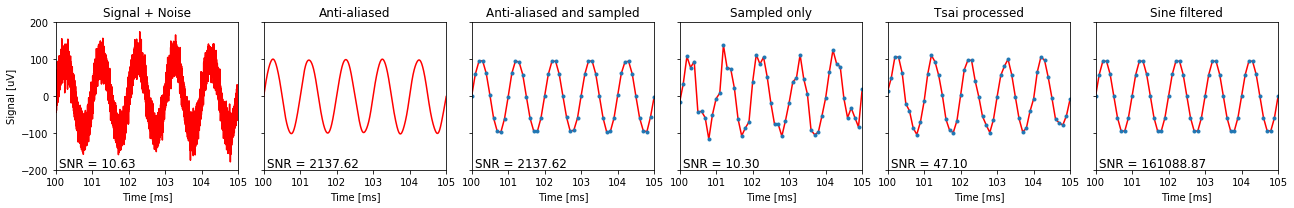

In [18]:
Sine_in_Noise()

We start by making the sine wave plus noise at a high sampling rate of 2 MS/s that accommodates the 1 MHz bandwidth, see panel "Signal + Noise". The number in the lower left is the ratio of signal power to noise power.

Then we follow the conventional process, which is to pass Signal + Noise through an anti-alias filter. The code simulates this analog hardware by applying a perfect cutoff for components above the 5 kHz Nyquist frequency. The result in panel "Anti-aliased" already has very little noise remaining, about 200 times less than in the raw signal, because the noise bandwidth was cut by a factor of 200.

The next step in the conventional process is to sample the signal at 10 kS/s, see panel "Anti-aliased and sampled".

For comparison, the process followed by Tsai et al is to sample the raw Signal + Noise without any filtering, see panel "Sampled only". This signal has the same poor signal-to-noise ratio as the raw Signal + Noise.

Then the sampled result gets passed through a digital processing algorithm, see "Tsai filtered". The Tsai filter is able to clean up the sine signal from SNR = 10.3 to SNR = 47.1, i.e. a power ratio of 4.6. This corresponds to a reduction in the rms noise amplitude by a factor of 2.1, i.e. from 21.7 µV rms to 10.1 µV rms. Note this is almost exactly the degree of noise reduction that the authors reported (p.5 of [2]). My code for this algorithm is in Filter_Tsai() above.

Finally, if we know the signal is a sine wave, we can extract it easily even from the very noisy "Sampled only" waveform. We simply assume that the largest Fourier component is that contributed by the sine wave, and suppress all the others. If the assumption holds one can get nearly complete noise elimination, see panel "Sine filtered". If it doesn't, for example if there is a mix of two sine signals, then this method fails. See code in Filter_Sine() above.

## Comparison of Tsai algorithm to Wiener Filter

Again, we compare two schemes of post-processing after sampling. Here the Signal is not a simple sine wave, but it has a spectrum that differs from that of the Noise. The Noise spectrum is flat over the full 5 kHz Nyquist range. But we will constrain the Signal spectrum to lower frequencies, and we will vary that cutoff frequency, as well as the magnitude of the signal. One expects that the more the Signal spectrum differs from the Noise, the more one should be able to extract it by post-hoc filtering.

The classic method for this estimation problem is the Wiener filter. This amounts to multiplying the Fourier transform by 
$\frac{S\left( f \right)}{S\left( f \right)+N\left( f \right)}$
where $S\left( f \right)$ and $N\left( f \right)$ are the power spectra of Signal and Noise respectively. For comparison, we apply the Tsai algorithm to the same problem. For both filters we measure the resulting signal-to-noise power ratio (SNR) and plot it against the SNR before filtering.


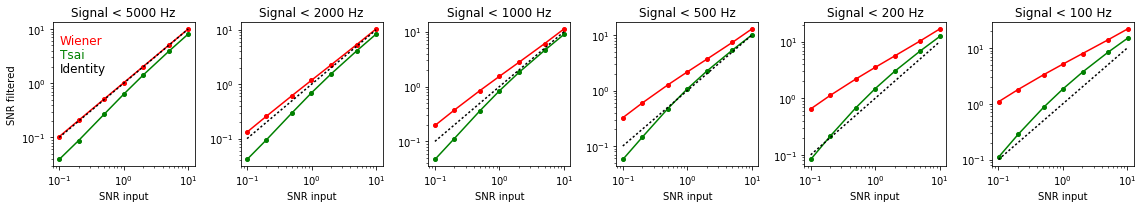

In [19]:
plot_Wiener_vs_Tsai()

The Wiener filter always improves the SNR (compare red to dotted), and more so the more the signal spectrum differs from the noise spectrum (left to right). The Tsai filter is always worse than the Wiener filter (compare red to green). And unless the signal and noise spectra differ dramatically (rightmost plots) the Tsai filter actually degrades the SNR (compare green to dotted). That means it is worse than doing nothing.

Code for the Wiener filter is a single line in Filter_Wiener() above.

## The $1000 Challenge

Here is code to practice your skills at reconstructing and removing aliased noise.

In [20]:
generate(rs=0, S_only='S_only', SN_raw='SN_raw')

This generates a pair of data files, one with pure signal, the other with signal + aliased noise. The signal has a bandwidth of 5 kHz and rms amplitude 100 uV. To that we add white noise with a bandwidth of 1 MHz and rms amplitude 21.7 uV. Then we sample the result at a sampling rate of 10 kS/s.

You provide 3 arguments to this function:
   rs = random seed for the simulation, 
   S_only = file name where to save the pure signal, 
   SN_raw = file name where to save the sampled signal + aliased noise 
    
If you take my challenge, I will use this code. I will keep the S_only file for myself, and send you the SN_raw file. Of course I won't tell you the random seed I used.

In [21]:
process(SN_raw='SN_raw', SN_processed='SN_processed')

Here is where you put your processing algorithm. You read the data in the file SN_raw, process it to remove the noise as much as possible, and save the result in file SN_processed. The current version in the code base above applies the Tsai et al algorithm. You may want to try something different for your own work.

In [22]:
evaluate(S_only='S_only', SN_raw='SN_raw', SN_processed='SN_processed')

SNR before processing = 20.9931549469
SNR after processing = 17.632042275
SNR gain = 0.839894828556


Finally you get to evaluate how well your algorithm did. This uses the S_only data file with the pure signal, the SN_raw file with the signal + aliased noise, and your result in the SN_processed file. It prints out the signal-to-noise power ratio both before and after your processing, and how much it improved. As you can see the Tsai et al algorithm did poorly, actually reducing the SNR. 

If you send me your SN_processed file, I will evaluate it with this function. That number for "SNR gain" needs to be greater than 2 to qualify you for the prize. 